# Dataset Import

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/cell-images-for-detecting-malaria.zip

Archive:  /content/cell-images-for-detecting-malaria.zip
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Detection of Malaria from Cell Images

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image

from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras import metrics
from keras import Model, layers
from keras.callbacks import *
from keras.models import load_model, model_from_json

Dataset can be downloaded from here: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [9]:
parasitized_data = os.listdir('/content/cell_images/Parasitized/')
uninfected_data = os.listdir('/content/cell_images/Uninfected/')


Images of malaria infected cells


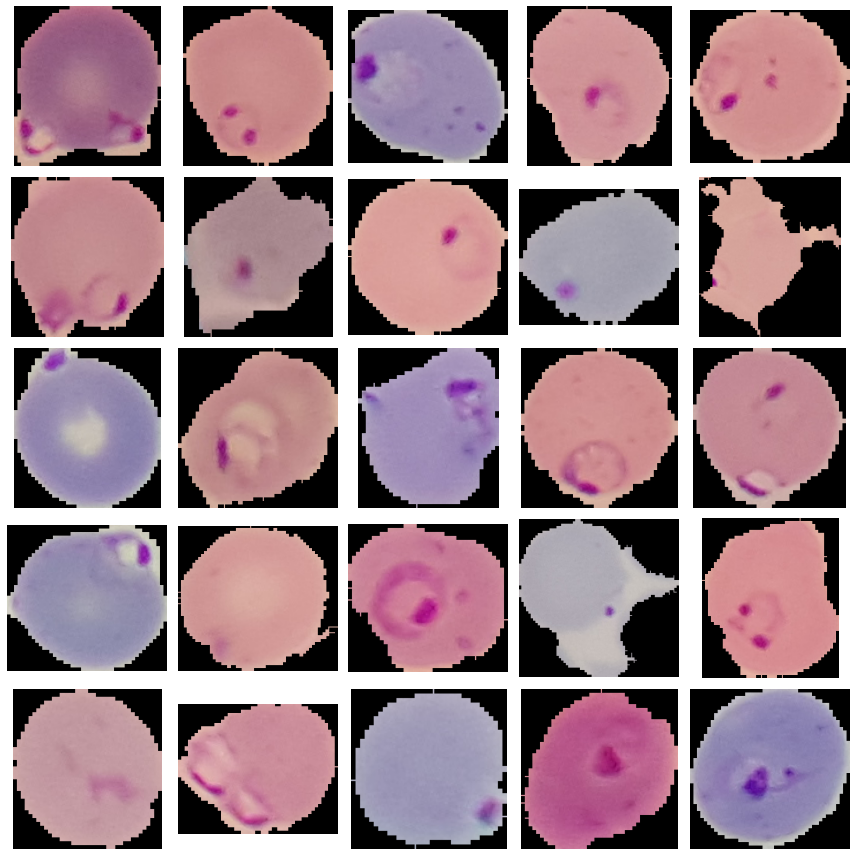

In [10]:
def plotImages(title,directory):
    print(title)
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread( directory+ "/" + parasitized_data[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.tight_layout()
    plt.show()
        
plotImages("Images of malaria infected cells","/content/cell_images/Parasitized") 

Images of Uninfected cells


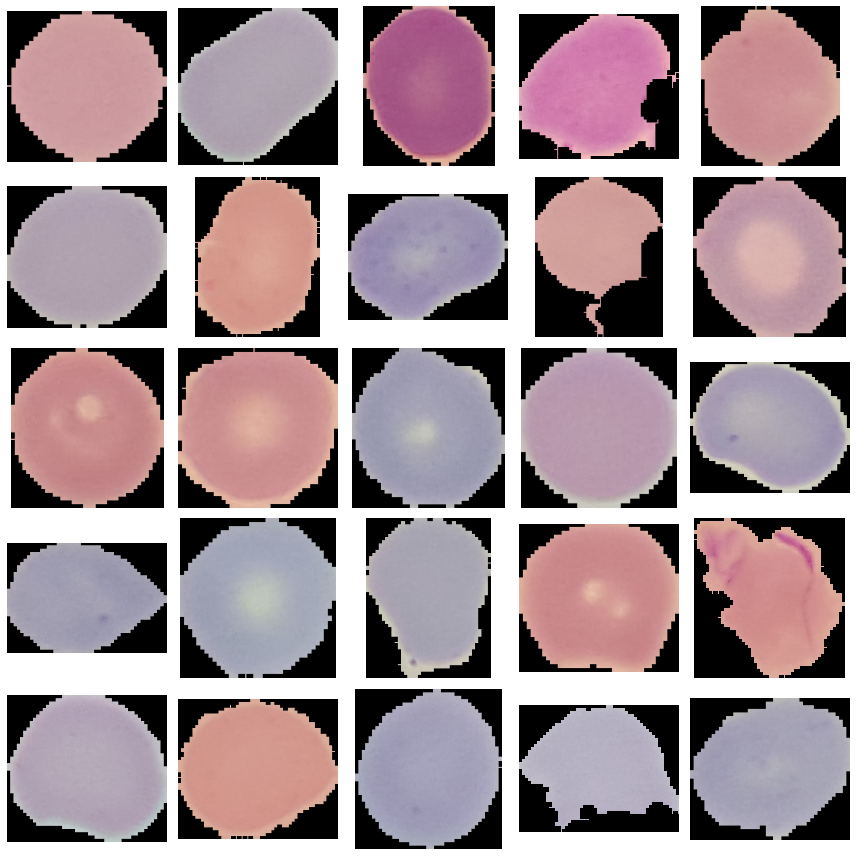

In [11]:
def plotImages(title,directory):
    print(title)
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread( directory+ "/" + uninfected_data[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.tight_layout()
    plt.show()
        
plotImages("Images of Uninfected cells","/content/cell_images/Uninfected/") 

We can clearly observe from images above the difference between the infected and uninfected cells. We can see a small pink colored clot inside the cellular image for infected while for the uninfected the cellular image is clean without any clots.

In [12]:
workingDir = "/content/"

PATH = os.path.sep.join([workingDir, "cell_images"])

# Getting the path ot the training directory 
train_dir = os.path.join(PATH, "cell_images")

# Getting the path to the validation directory 
validation_dir = os.path.join(PATH, "cell_images")

In [13]:
# Getting the path to the directory for the parasitized training cell images and 
# the getting the path to the directory for the uninfected training cell images 
parasitized_train_dir = os.path.join(train_dir, "Parasitized")
uninfected_train_dir = os.path.join(train_dir, "Uninfected")

# Getting the path to the directory for the parasitized validation cell images and 
# the path to the directory for the uninfected validation cell images 
parasitized_val_dir = os.path.join(validation_dir, "Parasitized") 
uninfected_val_dir = os.path.join(validation_dir, "Uninfected")

In [14]:
# Getting the number of images present in the parasitized training directory and the 
# number of images present in the uninfected training directory 
parasitized_images = len(os.listdir(parasitized_train_dir))
uninfected_images = len(os.listdir(uninfected_train_dir))

# Getting the number of images present in the parasitized validation directory and the 
# number of images present in the uninfected validation directory 
parasitized_images_val = len(os.listdir(parasitized_val_dir)) 
uninfected_images_val = len(os.listdir(uninfected_val_dir)) 

# Getting the sum of both the training images and validation images 
total_train = parasitized_images + uninfected_images  
total_val = parasitized_images_val + uninfected_images_val 

# Displaying the results for Training images  
print("Total Training parasitized images: {}".format(parasitized_images)); 
print("Total Training uninfected images: {}".format(uninfected_images)); 
print("__________________________________________________________________________________________________________\n");

# Displaying the results for Validation images  
print("Total Validation parasitized images: {}".format(parasitized_images_val)); 
print("Total Validation uninfected images: {}".format(uninfected_images_val)); 
print("__________________________________________________________________________________________________________\n"); 

# Displaying the total values for the images in both the training and validation directory 
print("Total Train: {}".format(total_train)); 
print("Total Validation: {}".format(total_val)); 

Total Training parasitized images: 13780
Total Training uninfected images: 13780
__________________________________________________________________________________________________________

Total Validation parasitized images: 13780
Total Validation uninfected images: 13780
__________________________________________________________________________________________________________

Total Train: 27560
Total Validation: 27560


#**DEFINING** MODEL USING CNN

In [15]:
#CNN
BATCH_SIZE_CNN = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE_CNN  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels
TARGET_SIZE_CNN = 64
EPOCHS_CNN = 2

In [16]:
# train test split
from sklearn.model_selection import train_test_split
# model performance metrics
from sklearn.metrics import confusion_matrix, classification_report

# utility functions
from tensorflow.keras.utils import to_categorical, plot_model
# process image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# sequential model
from tensorflow.keras.models import Sequential
# layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# callback functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [17]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE_CNN, IMG_SHAPE_CNN, 3)))
model_cnn.add(MaxPooling2D(2,2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(2,2))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(2,2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

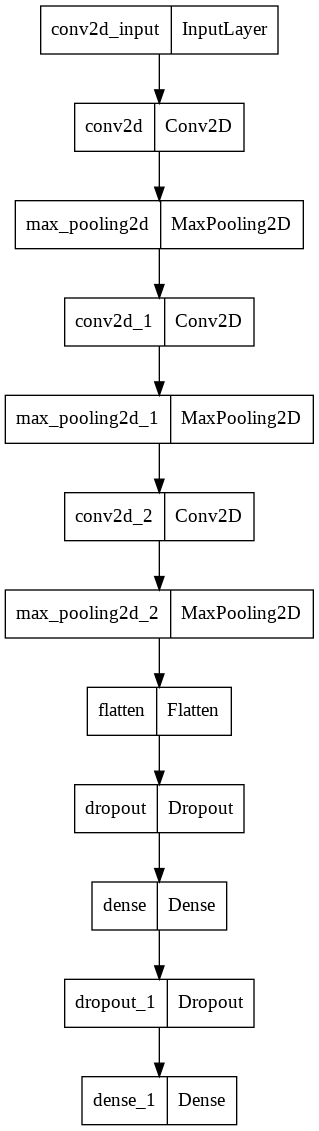

<Figure size 360x720 with 0 Axes>

In [18]:
plt.figure(figsize=(5, 10))
plot_model(model_cnn, to_file="model_cnn.png")

# New Section

In [19]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             validation_split=0.3)

train_data = datagen.flow_from_directory(directory = train_dir,
                                         target_size=(IMG_SHAPE_CNN,IMG_SHAPE_CNN),
                                         batch_size=BATCH_SIZE_CNN,
                                         shuffle=True,
                                         class_mode='binary',
                                         subset='training')

validation_data = datagen.flow_from_directory(directory = validation_dir,
                                              target_size=(IMG_SHAPE_CNN,IMG_SHAPE_CNN),
                                              batch_size=BATCH_SIZE_CNN,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='validation')

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [20]:
# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta = 0.01,
                               patience=5)

# Instantiate a model checkpoint callback
model_save = ModelCheckpoint('best_model.hdf5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

In [21]:
history_cnn = model_cnn.fit(train_data,
                    validation_data=validation_data,
                    epochs=EPOCHS_CNN,
                    verbose=1, 
                    callbacks=[early_stopping, model_save])

Epoch 1/2
 17/193 [=>............................] - ETA: 14:37 - loss: 0.8025 - accuracy: 0.5176

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
print(history_cnn.history['val_accuracy'][1])

In [ ]:
# validate the model on test dataset to determine generalization
_, acc = model_cnn.evaluate(validation_data,batch_size=128,verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

In [ ]:
predictions_cnn = model_cnn.predict(validation_data)
print("predictions shape:", predictions_cnn.shape)
print("predictions shape:", predictions_cnn)


#**DEFINING** MODEL USING VGG-16

In [ ]:
batch_size = 2000
epochs = 10
IMG_HEIGHT = 98 
IMG_WIDTH = 98 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(directory = validation_dir,
                                                  target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True
                                                 )

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
#VGG 16
# instantiating the VGG16 model
vgg16 = VGG16(input_shape=[IMG_HEIGHT, IMG_WIDTH] + [3],
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg16.layers:
  layer.trainable = False

# defining input and output to the model
x = Flatten()(vgg16.output)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
# create a model object
model_vgg16 = Model(inputs = vgg16.input, outputs = prediction)

# view the structure of the model
model_vgg16.summary()

In [ ]:
# tell the model what cost and optimization method to use

metrics_vgg16 = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
          ]

model_vgg16.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics_vgg16
)

In [ ]:
print(train_generator)

In [ ]:
# Training the model on the input data by using the fit_generator function 
history_vgg16 = model_vgg16.fit_generator(train_generator, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_generator, 
                       validation_steps = total_val // batch_size) 

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history_vgg16.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history_vgg16.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history_vgg16.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history_vgg16.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(history_vgg16)

In [ ]:
VGG16_model_test_performace = model_vgg16.evaluate(validation_generator)

#**DEFINING MODEL USING VGG-19**


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [ ]:
#VGG
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=[IMG_HEIGHT, IMG_WIDTH] + [3],
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = Flatten()(vgg19.output)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
# create a model object
model_vgg19 = Model(inputs = vgg19.input, outputs = prediction)

# view the structure of the model
model_vgg19.summary()

In [ ]:
# tell the model what cost and optimization method to use

metrics_vgg19 = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
          ]

model_vgg19.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics_vgg19
)

In [ ]:
# Training the model on the input data by using the fit_generator function 
history_vgg19 = model_vgg19.fit_generator(train_generator, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_generator, 
                       validation_steps = total_val // batch_size) 

In [ ]:
def visualize_training_vgg19(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history_vgg19.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history_vgg19.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history_vgg19.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history_vgg19.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training_vgg19(history_vgg19)

In [ ]:
VGG19_model_test_performace = model_vgg19.evaluate(validation_generator)

In [ ]:
predictions_VGG19 = model_vgg19.predict(validation_generator)
print("predictions shape:", predictions_VGG19.shape)
print("\n")
print("predictions shape:", predictions_VGG19)

In [ ]:
print(history_vgg19.history['val_accuracy'][1])

In [ ]:
# Saving the model for further uses 
modelName = "MalariaModel.h5" 
model_vgg19.save_weights(modelName); 
modelName

# **TABULATING RESULTS**

In [ ]:
acc_cnn=[history_cnn.history['val_accuracy'][1]]
acc_vgg16=[history_vgg16.history['val_accuracy'][1]]
acc_vgg19=[history_vgg19.history['val_accuracy'][1]]

In [ ]:
acc_cnn

In [ ]:
acc_vgg16

In [ ]:
acc_vgg19

In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = (['Accuracy of CNN','Accuracy of VGG16','Accuracy of VGG19'])
pt.add_row([acc_cnn,acc_vgg16,acc_vgg19])
pt

# As the accuracy of vgg is higher than cnn , vgg will be the best model 

# **PREDICTNG THE CLASS FO AN IMAGE WITH VGG MODEL**

In [ ]:
img = "/content/cell_images/Uninfected/"

# Getting the first Four images 
ImgDir = list(os.listdir(img)) 
ImgDir = ImgDir[:3] 

# Loading Just a random image from the Parasitized images folder. 
imagePath = os.path.join(img, "C100P61ThinF_IMG_20150918_144104_cell_34.png")

# Displaying the full path to the parasitized image we want to use for prediction. 
print(imagePath)

In [ ]:
print(img)

In [ ]:
img = cv2.imread(imagePath); 
# Setting the dimensions for the loaded image to be converted into and displaying the shape of the image 
print("Loaded Image Shape: {}".format(img.shape)); 
dim = (IMG_HEIGHT, IMG_WIDTH); 

# Resizing the image 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA); 
plt.grid(False) 
plt.imshow(img) 
plt.show() 

# Expanding the image dimensions 
image = np.expand_dims(img, axis = 0); 

# Making Final Predictions 
result = model_vgg16.predict(image)
#print("res is :",result)
print(result)
# Creating a loop to get the actual predicted class 
for key, value in (train_generator.class_indices.items()): 
    if value == result: 
        #print("The Predicted Class is: {}".format(key))
        #print("val  in if stat:",value)
        #
        print()
    else:
      #print("value : ",value)
      print()
if(result>1):
  print("Parasitized")
else:
  print("Uninfected")


In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
#load the trained model to classify sign
from keras.models import load_model
model = load_model('/content/best_model.hdf5')
#dictionary to label all traffic signs class.
classes = { 1:'Parasitized',
            2:'Uninfected' }
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Malaria detection from blood cell images')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((30,30))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred = model.predict_classes([image])[0]
    sign = classes[pred+1]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Know Your Traffic Sign",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

In [ ]:
%%shell
jupyter nbconvert --to html /content/DL_PROJECT.ipynb